In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

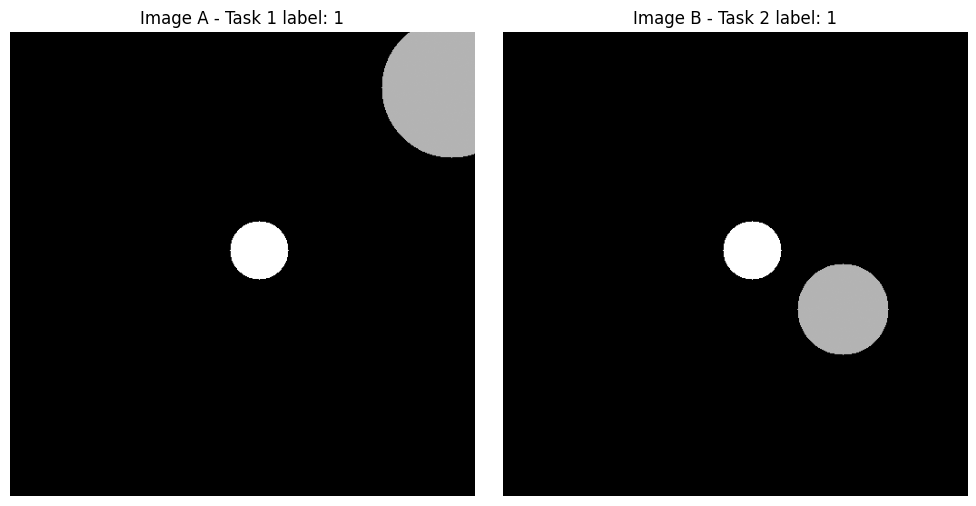

In [2]:


IMG_SIZE = 512
LATENT_DIM = 4

def draw_blob(image, center, radius, color=255):
    cv2.circle(image, center, radius, color, -1)

def latent_to_position(z, img_size):
    return tuple(((z[:2] + 1) / 2 * img_size).astype(int))  # map [-1, 1] -> [0, img_size]

def latent_to_radius(z, min_radius=20, max_radius=80):
    return int(((z[2] + 1) / 2) * (max_radius - min_radius) + min_radius)

def generate_sample():
    # Latents
    z_shared = np.random.uniform(-1, 1, LATENT_DIM)
    z_a = np.random.uniform(-1, 1, LATENT_DIM)
    z_b = np.random.uniform(-1, 1, LATENT_DIM)

    # Images
    img_a = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    img_b = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    # Shared blob
    shared_center = latent_to_position(z_shared, IMG_SIZE)
    shared_radius = latent_to_radius(z_shared)
    draw_blob(img_a, shared_center, shared_radius)
    draw_blob(img_b, shared_center, shared_radius)

    # Private blobs
    private_a_center = latent_to_position(z_a, IMG_SIZE)
    private_a_radius = latent_to_radius(z_a)
    draw_blob(img_a, private_a_center, private_a_radius, color=180)

    private_b_center = latent_to_position(z_b, IMG_SIZE)
    private_b_radius = latent_to_radius(z_b)
    draw_blob(img_b, private_b_center, private_b_radius, color=180)

    # Labels (based on simple thresholds of latent sums)
    task1_label = np.digitize(np.sum(z_shared + z_a), [-1.5, 1.5])  # 0, 1, 2
    task2_label = np.digitize(np.sum(z_shared + z_b), [-1.5, 1.5])  # 0, 1, 2

    return img_a, img_b, task1_label, task2_label

# Visualize one pair
img_a, img_b, label1, label2 = generate_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

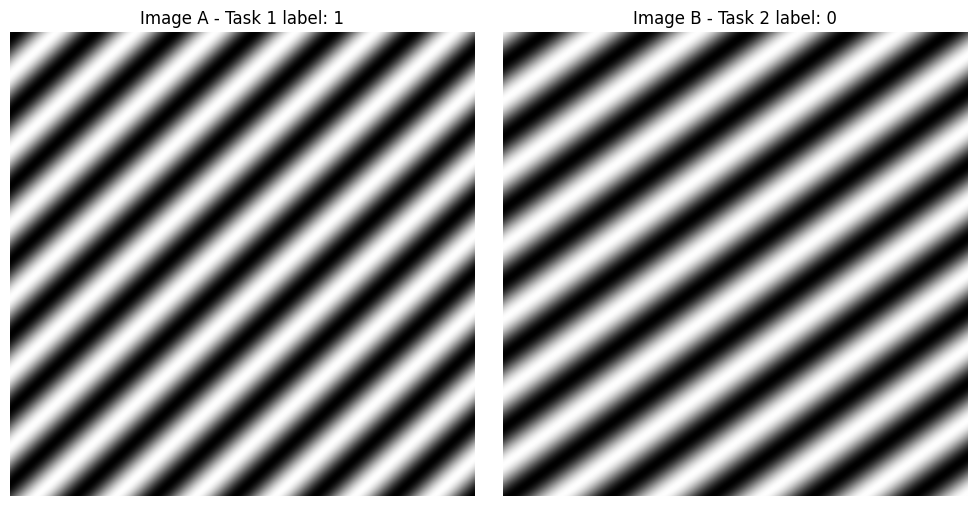

In [3]:
IMG_SIZE = 512
LATENT_DIM = 4

def generate_sinusoidal_pattern(z, img_size):
    A = (z[0] + 1) * 0.5  # amplitude in [0, 1]
    fx = (z[1] + 1) * 5   # frequency x in [0, 10]
    fy = (z[2] + 1) * 5   # frequency y
    phi = (z[3]) * np.pi # phase in [-π, π]

    x = np.linspace(0, 2 * np.pi, img_size)
    y = np.linspace(0, 2 * np.pi, img_size)
    X, Y = np.meshgrid(x, y)

    wave = A * np.sin(fx * X + fy * Y + phi)
    image = ((wave - wave.min()) / (wave.max() - wave.min()) * 255).astype(np.uint8)
    return image

def generate_sinusoidal_sample():
    z_shared = np.random.uniform(-1, 1, LATENT_DIM)
    z_a = np.random.uniform(-1, 1, LATENT_DIM)
    z_b = np.random.uniform(-1, 1, LATENT_DIM)

    img_a = generate_sinusoidal_pattern(z_shared + 0.5 * z_a, img_size = IMG_SIZE)
    img_b = generate_sinusoidal_pattern(z_shared + 0.5 * z_b, img_size = IMG_SIZE)

    task1_label = np.digitize(np.sum(z_shared + z_a), [-1.5, 1.5])
    task2_label = np.digitize(np.sum(z_shared + z_b), [-1.5, 1.5])

    return img_a, img_b, task1_label, task2_label

# Visualize
img_a, img_b, label1, label2 = generate_sinusoidal_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

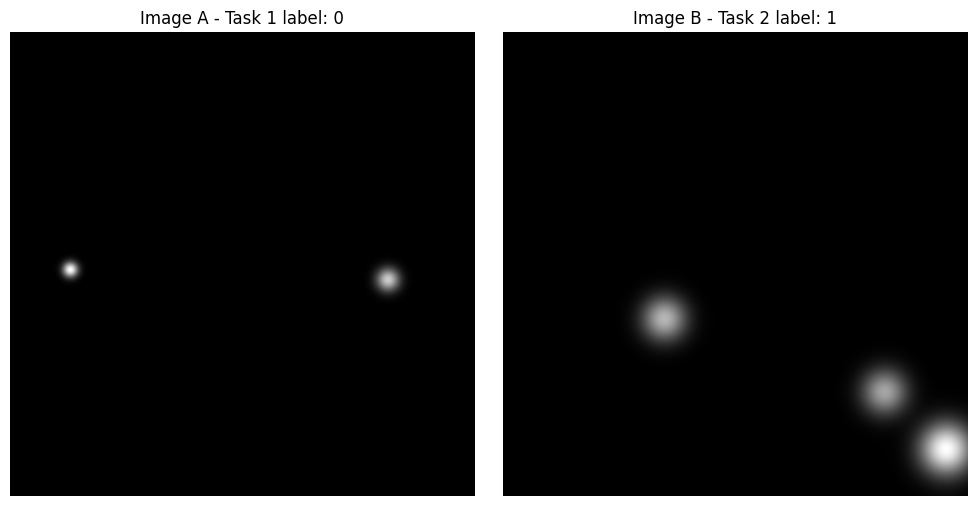

In [4]:


IMG_SIZE = 512
LATENT_DIM = 4
N_SPOTS = 3

def draw_gaussians(zs, img_size, n_spots=3):
    img = np.zeros((img_size, img_size), dtype=np.float32)
    x = np.linspace(0, 1, img_size)
    y = np.linspace(0, 1, img_size)
    X, Y = np.meshgrid(x, y)

    for i in range(n_spots):
        x0 = (zs[i*4+0] + 1) / 2  # [0, 1]
        y0 = (zs[i*4+1] + 1) / 2
        sigma = 0.02 + 0.08 * ((zs[i*4+2] + 1) / 2)  # spread
        amp = 0.5 + 0.5 * ((zs[i*4+3] + 1) / 2)      # amplitude

        gauss = amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        img += gauss

    img = np.clip(img / img.max(), 0, 1)
    return (img * 255).astype(np.uint8)

def generate_gaussian_sample():
    z_shared = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)
    z_a = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)
    z_b = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)

    img_a = draw_gaussians(z_shared + 0.5 * z_a, IMG_SIZE, N_SPOTS)
    img_b = draw_gaussians(z_shared + 0.5 * z_b, IMG_SIZE, N_SPOTS)

    task1_label = np.digitize(np.sum(z_shared + z_a), [-2, 2])
    task2_label = np.digitize(np.sum(z_shared + z_b), [-2, 2])

    return img_a, img_b, task1_label, task2_label

# Visualize one sample
img_a, img_b, label1, label2 = generate_gaussian_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [29]:
IMG_SIZE = 512
LATENT_DIM = 4

def generate_sinusoidal_pattern(z, img_size):
    fx = z[0]   # frequency x in [0, 10]
    fy = z[1]   # frequency y
    phi = (2*np.pi*z[2]) - np.pi  # phase in [-π, π]

    x = np.linspace(-np.pi, np.pi, img_size)
    y = np.linspace(-np.pi, np.pi, img_size)
    X, Y = np.meshgrid(x, y)

    wave = np.sin(fx * X + fy * Y + phi)

    # Apply exponential decay
    decay = np.exp(-((X)**2 + (Y)**2) / (2 * (np.pi / 2)**2))
    wave *= decay
    
    # flip the image vertically with 50% chance
    if np.random.rand() > 0.5:
        wave = np.flipud(wave)

    image = ((wave - wave.min()) / (wave.max() - wave.min()) * 255).astype(np.uint8)
    return image

def generate_sinc_pattern(z, img_size):
    a = z[0] # main axis in [0, 2]
    b = z[1] # minor axis in [0, 2]
    theta = np.pi*z[2]  # rotation angle in [0, π]

    x = np.linspace(-10, 10, img_size)
    y = np.linspace(-10, 10, img_size)
    X, Y = np.meshgrid(x, y)

    # Rotation transformation
    X_rot = X * np.cos(theta) - Y * np.sin(theta)
    Y_rot = X * np.sin(theta) + Y * np.cos(theta)

    sinc_wave = np.sinc((X_rot/a)**2 + (Y_rot/b)**2)

    image = ((sinc_wave - sinc_wave.min()) / (sinc_wave.max() - sinc_wave.min()) * 255).astype(np.uint8)
    return image
    

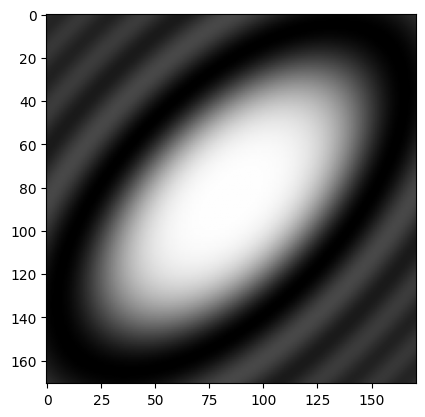

In [11]:
plt.imshow(generate_sinc_pattern(np.array([5, 10, 135/180]), img_size = int(np.ceil(IMG_SIZE / 3))), cmap='gray')

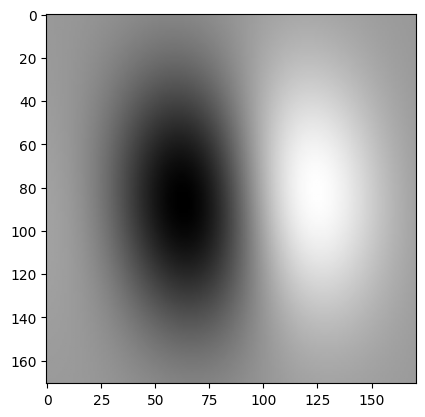

In [10]:
plt.imshow(generate_sinusoidal_pattern(np.array([np.random.rand()/10+0.9, np.random.rand()/5, np.random.rand()]), img_size = int(np.ceil(IMG_SIZE / 3))), cmap='gray')

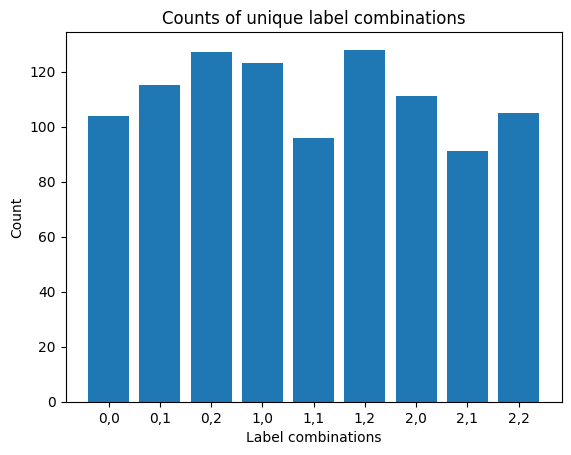

In [26]:
labels = np.random.randint(0, 3, size=(1000, 2))

unique, counts = np.unique(labels, axis=0, return_counts=True)
plt.bar([f"{a},{b}" for a, b in unique], counts)
plt.xlabel("Label combinations")
plt.ylabel("Count")
plt.title("Counts of unique label combinations")
plt.show()

In [35]:
def image_generator(task1, task2, img_size = 513):
    sub_img_size = img_size // 3 + 1
            
    match task1:
        case 1:
            task1_indiv1 = [[0,2],[7,8]]
            task1_indiv2 = [[11,12],[0,2]]
            task1_shared = [[1,3],[1,3]]
        case 2:
            task1_indiv1 = [[0,2],[9,10]]
            task1_indiv2 = [[9,10],[0,2]]
            task1_shared = [[4,6],[4,6]]
        case 3:
            task1_indiv1 = [[0,2],[11,12]]
            task1_indiv2 = [[7,8],[0,2]]
            task1_shared = [[7,9],[7,9]]
        case _:
            result = "Wrong class label"
            
    match task2:
        case 1:
            task2_indiv1 = [[1, 2.5],  2, [30/180,60/180]]
            task2_indiv2 = [[3.5, 5],  4, [120/180,150/180]]
            task2_shared = [[1,5], 2, [-15/180,15/180]]
        case 2:
            task2_indiv1 = [[1, 2.5],  2.5, [30/180,60/180]]
            task2_indiv2 = [[3.5, 5],  3, [120/180,150/180]]
            task2_shared = [[1,5], 2.5, [-15/180,15/180]]
        case 3:
            task2_indiv1 = [[1, 2.5],  3, [30/180,60/180]]
            task2_indiv2 = [[3.5, 5],  2, [120/180,150/180]]
            task2_shared = [[1,5], 3, [-15/180,15/180]]
        case _:
            print("Wrong class label")
    
    task1_indiv1 = generate_sinusoidal_pattern([random.uniform(task1_indiv1[0][0],task1_indiv1[0][1]), random.uniform(task1_indiv1[1][0],task1_indiv1[1][1]), random.random()], img_size = sub_img_size)
    task1_indiv2 = generate_sinusoidal_pattern([random.uniform(task1_indiv2[0][0],task1_indiv2[0][1]), random.uniform(task1_indiv2[1][0],task1_indiv2[1][1]), random.random()], img_size = sub_img_size)
    task1_shared = generate_sinusoidal_pattern([random.uniform(task1_shared[0][0],task1_shared[0][1]), random.uniform(task1_shared[1][0],task1_shared[1][1]), random.random()], img_size = sub_img_size)
    
    
    task2_indiv1 = generate_sinc_pattern(random.uniform(task2_indiv1[0][0],task2_indiv1[0][1])*np.array([1, task2_indiv1[1], 0]) + np.array([0, 0, random.uniform(task2_indiv1[2][0],task2_indiv1[2][1])]), img_size = sub_img_size)
    task2_indiv2 = generate_sinc_pattern(random.uniform(task2_indiv2[0][0],task2_indiv2[0][1])*np.array([1, task2_indiv2[1], 0]) + np.array([0, 0, random.uniform(task2_indiv2[2][0],task2_indiv2[2][1])]), img_size = sub_img_size)
    task2_shared = generate_sinc_pattern(random.uniform(task2_shared[0][0],task2_shared[0][1])*np.array([1, task2_shared[1], 0]) + np.array([0, 0, random.uniform(task2_shared[2][0],task2_shared[2][1])]), img_size = sub_img_size)
    
    fill = np.zeros((sub_img_size, sub_img_size), dtype=np.uint8)

    view1 = np.block([[task1_shared, task1_indiv1, fill],
                      [task1_indiv1, fill, task2_indiv1],
                      [fill, task2_indiv1, task2_shared]])
    
    view2 = np.block([[task1_indiv2, task1_shared, task1_indiv2],
                      [fill, fill, fill],
                      [task2_indiv2, task2_shared, task2_indiv2]])
    
    return [view1, view2], [task1, task2]

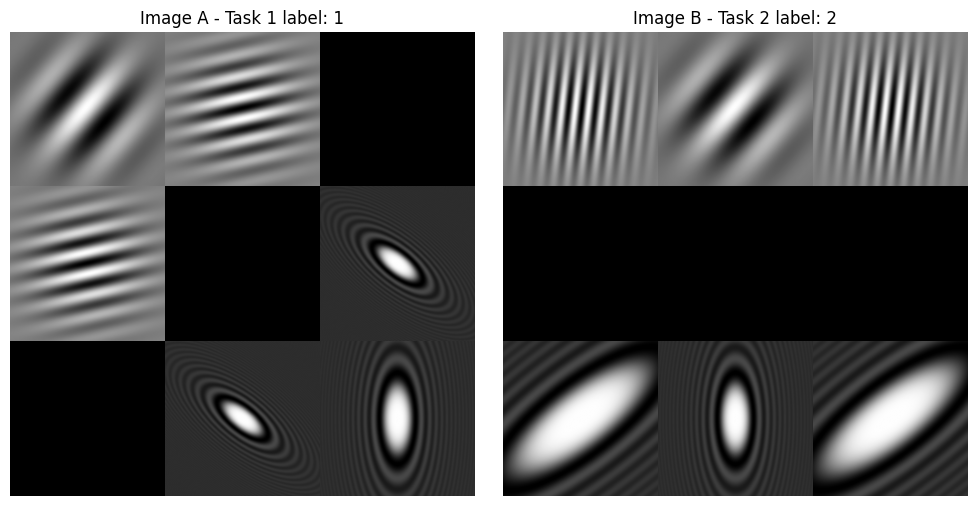

In [36]:
imgs, labs = image_generator(1, 2, img_size = IMG_SIZE)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(imgs[0], cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {labs[0]}')
axes[1].imshow(imgs[1], cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {labs[1]}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [51]:
import torch
import torchvision.transforms.v2 as T
view1, view2 = imgs
images = np.stack([view1, view2], axis=0).astype(np.float32)
tensor_images = torch.from_numpy(images).unsqueeze(1)
transform = T.Compose([
            T.Resize((512, 512)),  # expects (C, H, W)
            T.Normalize(mean=[0.0], std=[255.0])       # normalize to [0,1]
        ])


tensor_images = torch.stack([transform(img) for img in tensor_images], dim=0)
images.shape


(2, 513, 513)

In [3]:
import torchvision.transforms.v2 as T
transform = T.Compose([
            T.RandomHorizontalFlip(0.5),
            T.RandomVerticalFlip(0.5),
            T.GaussianNoise(0.1, 0.1),
        ])
loader = Synthetic_2v_Dataloader(transform=transform)



(0.9987911581993103, 0.0)

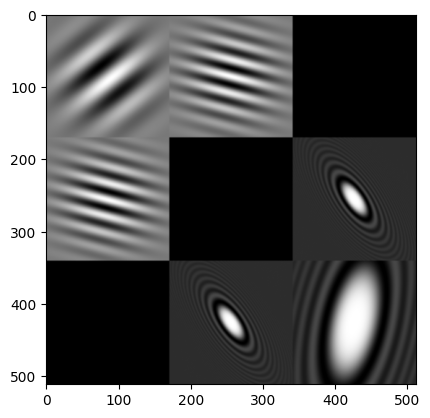

In [ ]:
image_view0 = torch.load('/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/UiT/FYS-8603/synthetic_images/train/image_0_view_0.pt', weights_only=True)
plt.imshow(image_view0[0].numpy(), cmap='gray')

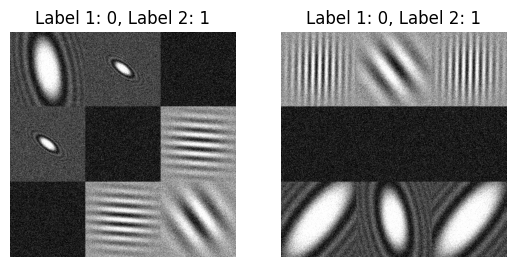

In [4]:
loader.train_dataset.plot(0)

In [1]:
from src import *

In [2]:
net = ResNeXt(
    cardinality=4,
    depth=20,
    nlabels=3,
    base_width=2,
    widen_factor=2
)

8
8
16
16
32
32


In [3]:
from torchsummary import summary

summary(net, input_size=(1, 512, 512))

torch.Size([2, 1, 512, 512])
torch.Size([2, 4, 512, 512])
torch.Size([2, 8, 512, 512])
torch.Size([2, 16, 256, 256])
torch.Size([2, 32, 128, 128])
torch.Size([2, 32, 2, 2])
torch.Size([2, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              32
       BatchNorm2d-2          [-1, 8, 512, 512]              16
 ResNeXtBottleneck-3          [-1, 8, 512, 512]               0
 ResNeXtBottleneck-4          [-1, 8, 512, 512]               0
            Conv2d-5         [-1, 16, 256, 256]             128
       BatchNorm2d-6         [-1, 16, 256, 256]              32
 ResNeXtBottleneck-7         [-1, 16, 256, 256]               0
 ResNeXtBottleneck-8         [-1, 16, 256, 256]               0
            Conv2d-9         [-1, 32, 128, 128]             512
      BatchNorm2d-10         [-1, 32, 128, 128]              64
ResNeXtBottleneck-11         [-1, 32,

In [4]:
print(net)

ResNeXt(
  (conv_1_3x3): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage_1): Sequential(
    (stage_1_bottleneck_0): ResNeXtBottleneck(
      (conv_reduce): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_reduce): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_expand): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_expand): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (shortcut_conv): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (shortcut_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine